# 1. importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

import warnings
warnings.filterwarnings("ignore")

# 2. Reading Required Data

The data is collected from 2 sources. Data files are shared in the github repository and the data source along with license is shared in the final report.

In [2]:
# loading vaccination data 
df_Vaccinations_by_Day_by_County = pd.read_csv('COVID-19_Vaccinations_by_Day_by_County_of_Residence_Current_Health.csv')
# covid masking policy data from common analysis
df_covid_masking_combined = pd.read_csv('AlleghenyCounty_combined.csv')

In [3]:
# selecting data for required county
df_Vaccinations_Allegheny = df_Vaccinations_by_Day_by_County.loc[df_Vaccinations_by_Day_by_County['County Name'] == 'Allegheny']

# 3. Data Preprocessing
- The raw data collected was in cumulative form and this csection convers it into a daily level data. 
- The date columns were marked as object, converted them into datetime variables using pandas.
- Performed logic based impuation for missing values in the data

In [4]:
# converting to date and time
df_covid_masking_combined['date'] = pd.to_datetime(df_covid_masking_combined['date'], format = '%Y-%m-%d')
df_Vaccinations_Allegheny['Date'] = pd.to_datetime(df_Vaccinations_Allegheny['Date'], format = '%m/%d/%Y')

In [5]:
print(df_covid_masking_combined['date'].min(), df_covid_masking_combined['date'].max())
print(df_Vaccinations_Allegheny['Date'].min(), df_Vaccinations_Allegheny['Date'].max())

2020-01-22 00:00:00 2022-10-31 00:00:00
2020-12-14 00:00:00 2022-11-22 00:00:00


In [6]:
df_Vaccinations_Allegheny.isnull().sum()

Date                      0
County Name               0
Partially Vaccinated      0
Fully Vaccinated         13
First Booster Dose      284
Second Booster Dose     552
Bivalent Booster 1      627
dtype: int64

In [7]:
df_covid_masking_combined.isnull().sum()

date                             0
confirmed_cases                  0
Face_Masks_Required_in_Public    0
death                            0
current_population               0
change_in_daily_cases            1
dtype: int64

In [8]:
# selecting data till feb because of unavailbiliy and inconsistency in future
df_Vaccinations_Allegheny_sub = df_Vaccinations_Allegheny.loc[df_Vaccinations_Allegheny['Date']< '2022-05-10']
df_covid_masking_combined_sub = df_covid_masking_combined.loc[df_covid_masking_combined['date']< '2022-05-10']

In [9]:
# filling missing values
df_Vaccinations_Allegheny.fillna(method = "bfill", inplace=True)

# 4. Feature Engineering

In [10]:
# calculating daily count of death
df_covid_masking_combined_sub['daily_death'] = df_covid_masking_combined_sub['death'] - df_covid_masking_combined_sub['death'].shift(1)

In [11]:
# updating daily level population
df_covid_masking_combined_sub['current_population'] = 0
df_covid_masking_combined_sub['current_population'][0] = 1250578 

In [12]:
# updating daily level population
for i in range(1, len(df_covid_masking_combined_sub)):
    df_covid_masking_combined_sub['current_population'][i] = df_covid_masking_combined_sub['current_population'][i-1] - df_covid_masking_combined_sub['daily_death'][i]- df_covid_masking_combined_sub['change_in_daily_cases'][i]

In [13]:
# calculating rate of infection
df_covid_masking_combined_sub['rate_of_infection'] = (df_covid_masking_combined_sub['change_in_daily_cases']/df_covid_masking_combined_sub['current_population'])
# calculating derivative of rate of infection
df_covid_masking_combined_sub['change_rate_of_infection'] = df_covid_masking_combined_sub['rate_of_infection'] - df_covid_masking_combined_sub['rate_of_infection'].shift(1)

# 5. Data Analysis

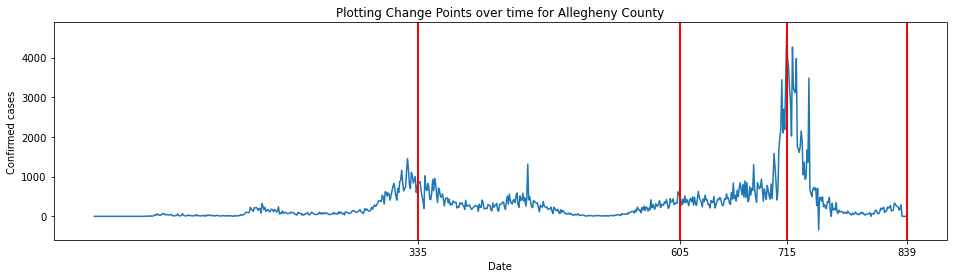

In [18]:
# change in point detection
algo1 = rpt.Pelt(model="rbf").fit(np.array(df_covid_masking_combined_sub['confirmed_cases']))
change_location1 = algo1.predict(pen=20)

# plotting
plt.figure(figsize=(16,4))
plt.plot(df_covid_masking_combined_sub['change_in_daily_cases'])
for x in change_location1:
        plt.axvline(x,lw=2, color='red')
plt.xticks(change_location1)
plt.title('Plotting Change Points over time for Allegheny County')
plt.savefig('plot1_changepoint_detection.jpeg')
plt.xlabel("Date")
plt.ylabel("Confirmed cases")
plt.show()

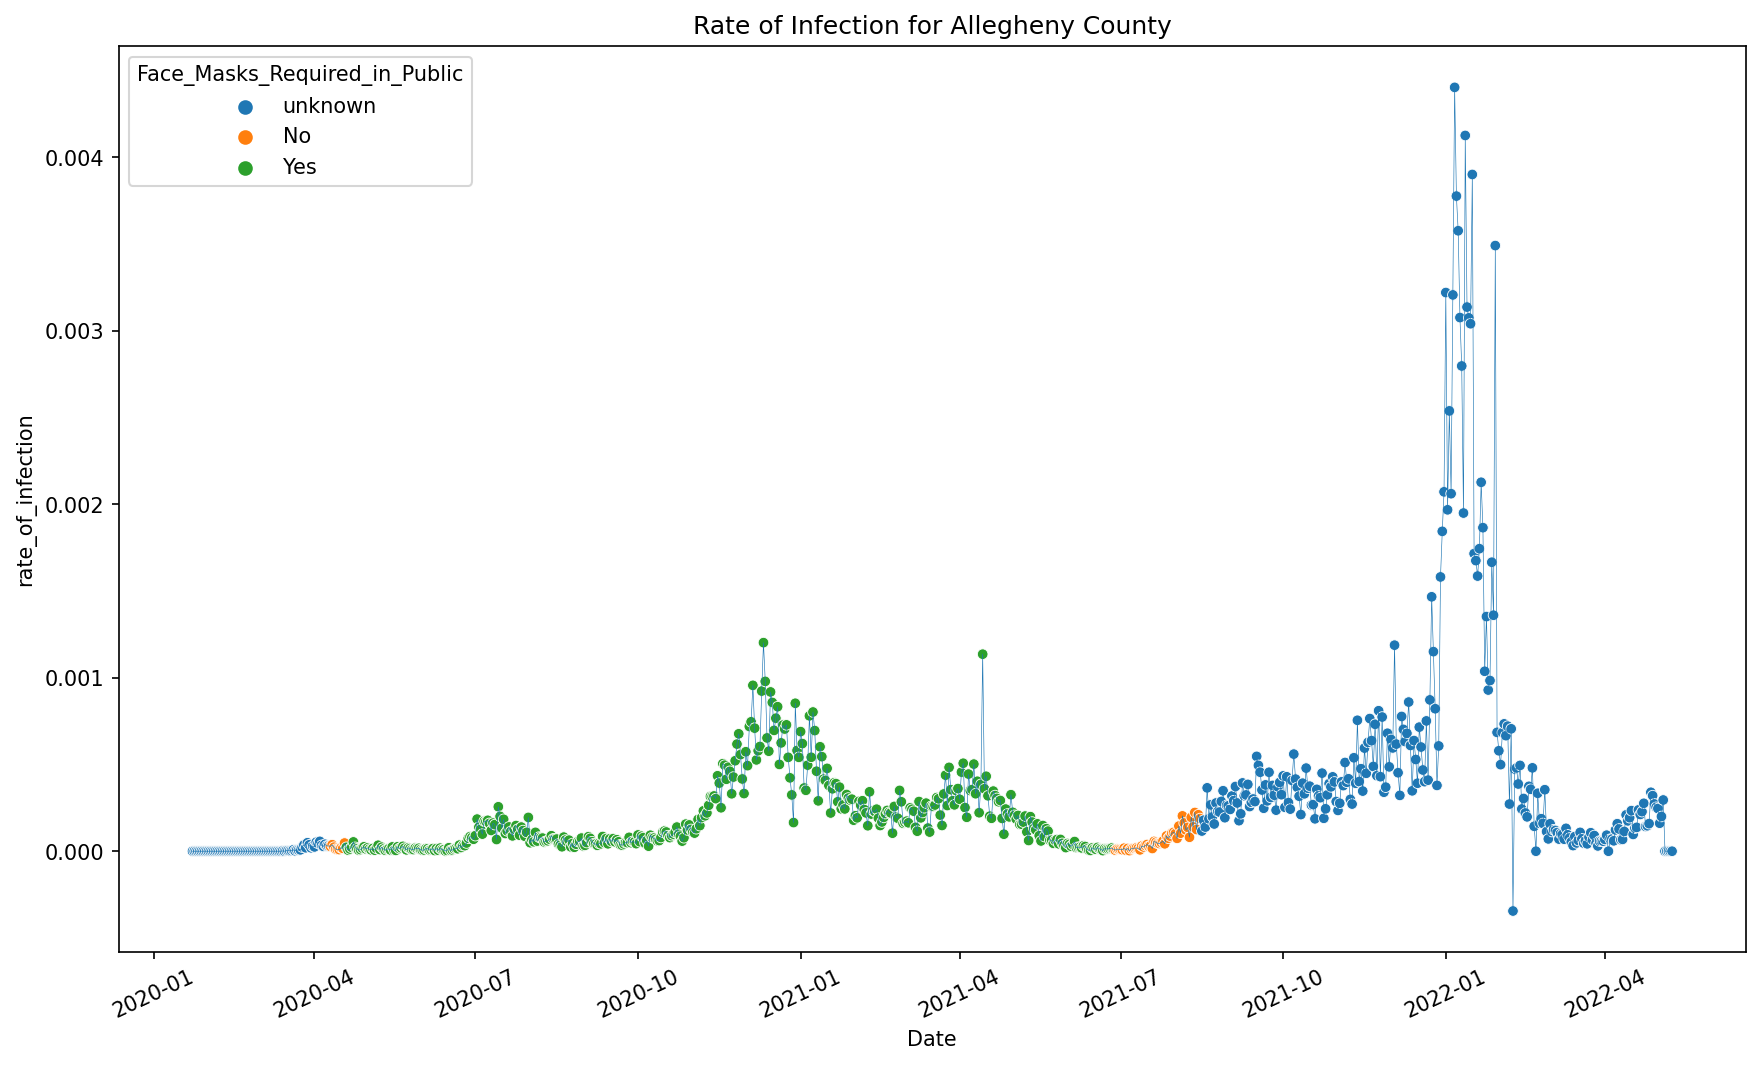

In [19]:
# create the time series plot for masking policy and change in rate of infection
plt.figure(figsize=(14,8), dpi = 150)
sns.lineplot(x = "date", y = "rate_of_infection", data = df_covid_masking_combined_sub, linewidth = 0.3)
sns.scatterplot(x = "date", y = "rate_of_infection", data = df_covid_masking_combined_sub,  
                hue='Face_Masks_Required_in_Public', s = 26)

plt.xlabel('Date')
plt.title('Rate of Infection for Allegheny County')
plt.savefig('plot2_masking_policy_vs_masks.jpeg')
plt.xticks(rotation = 25)
plt.show()

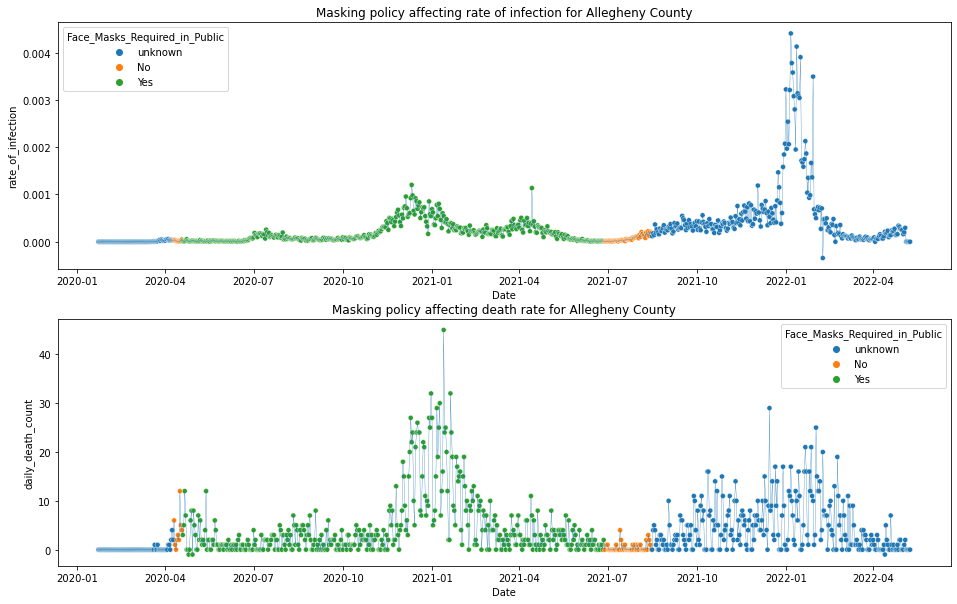

In [20]:
# create the time series plot for masking policy and change in rate of infection along with death trend

fig, axes = plt.subplots(2, 1, sharex=False, figsize=(16,10))
sns.lineplot(ax = axes[0],  x = "date", y = "rate_of_infection", data = df_covid_masking_combined_sub, linewidth = 0.3)
sns.scatterplot(ax = axes[0], x = "date", y = "rate_of_infection", data = df_covid_masking_combined_sub,  
                hue='Face_Masks_Required_in_Public', s = 26)

sns.lineplot(ax = axes[1], x = "date", y = "daily_death", data = df_covid_masking_combined_sub, linewidth = 0.3)
sns.scatterplot(ax = axes[1], x = "date", y = "daily_death", data = df_covid_masking_combined_sub,  
                hue='Face_Masks_Required_in_Public', s = 26)

# Set common labels
axes[0].set_xlabel('Date')
axes[0].set_ylabel('rate_of_infection')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('daily_death_count')

axes[0].set_title('Masking policy affecting rate of infection for Allegheny County')
axes[1].set_title('Masking policy affecting death rate for Allegheny County')
plt.savefig('plot3_masking_policy_and_death_vs_masks.jpeg')
plt.show()

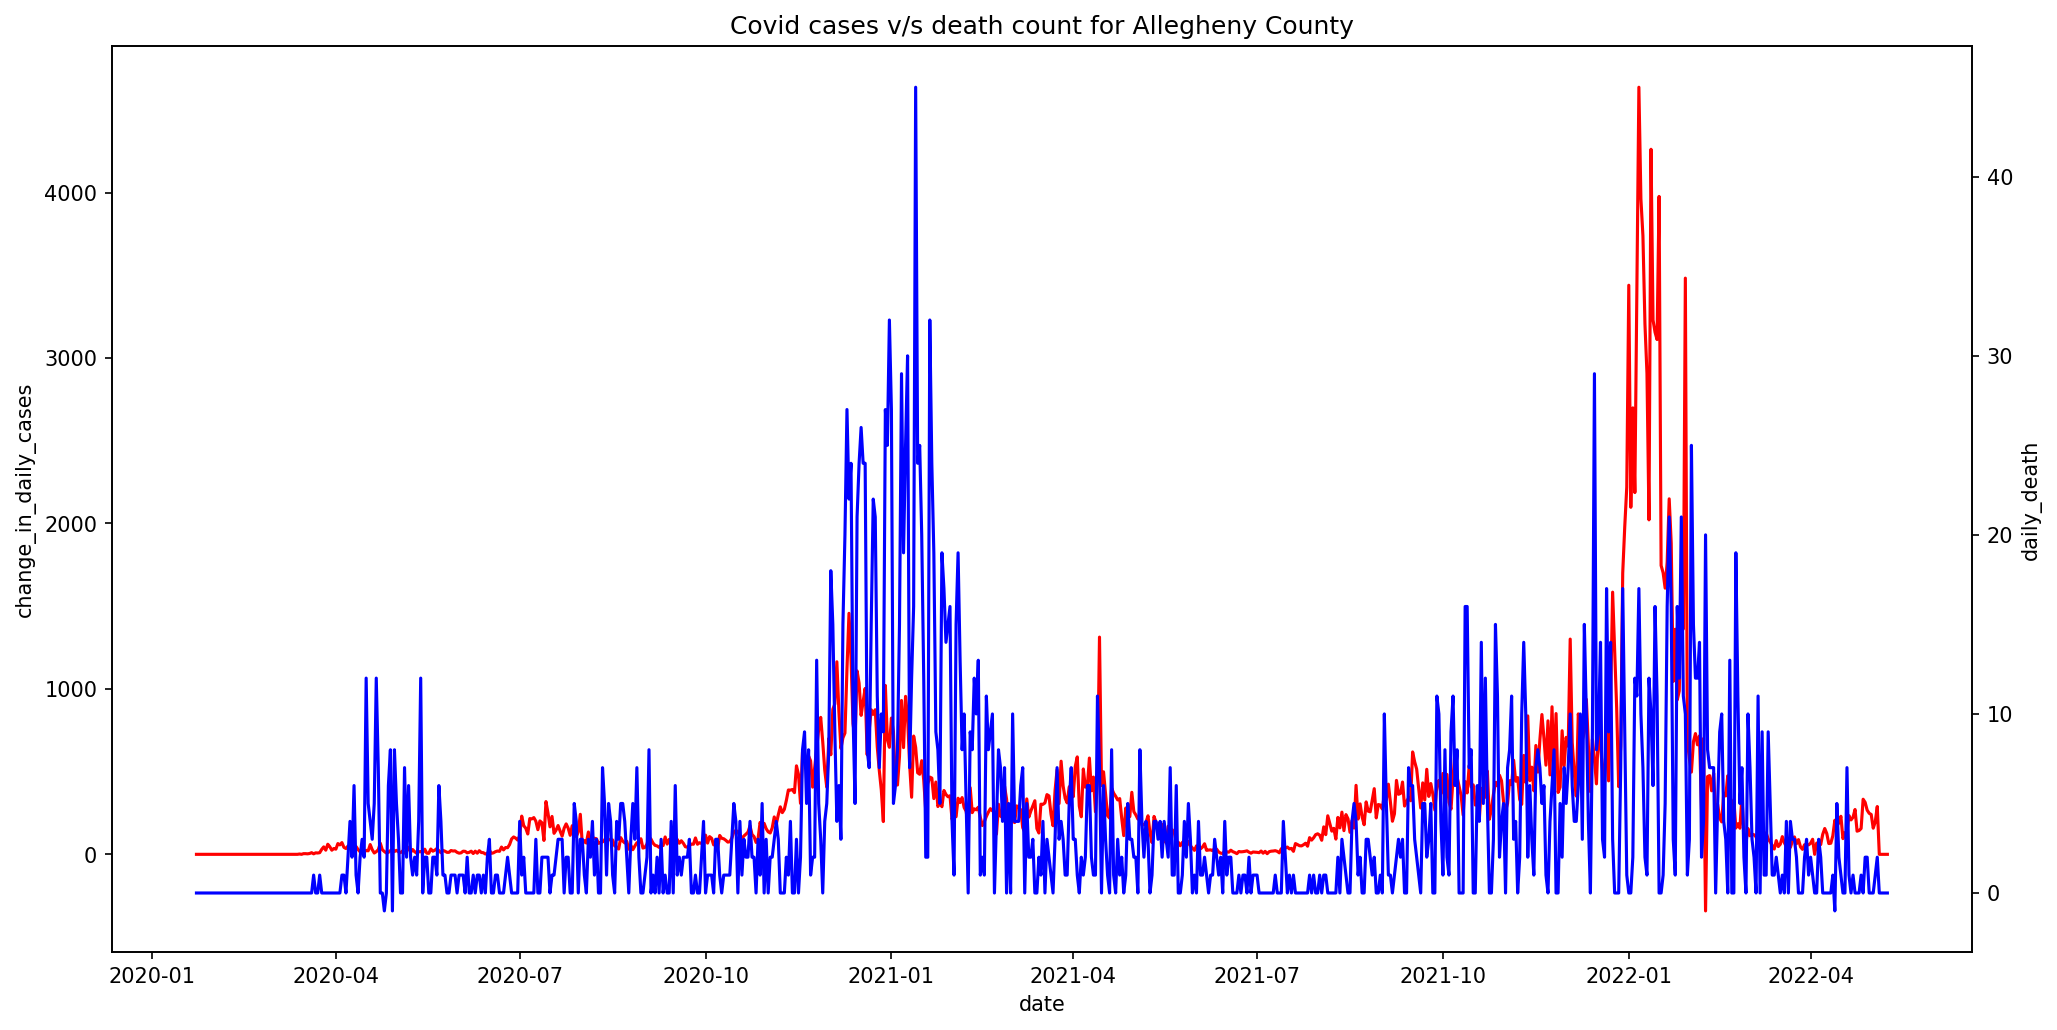

In [24]:
# covid cases versus death count at daily level

plt.figure(figsize=(16,8), dpi = 150)
sns.lineplot(x = "date", y = "change_in_daily_cases", data = df_covid_masking_combined_sub, color = 'r')
ax2 = plt.twinx()
sns.lineplot(x = "date", y = "daily_death", data = df_covid_masking_combined_sub, color = 'b',ax=ax2)

plt.xlabel('Date')
plt.ylabel('daily_death')
plt.title('Covid cases v/s death count for Allegheny County')
plt.xticks(rotation = 25)
plt.savefig('plot4_confirmed_cases_vs_death.jpeg')
plt.show()

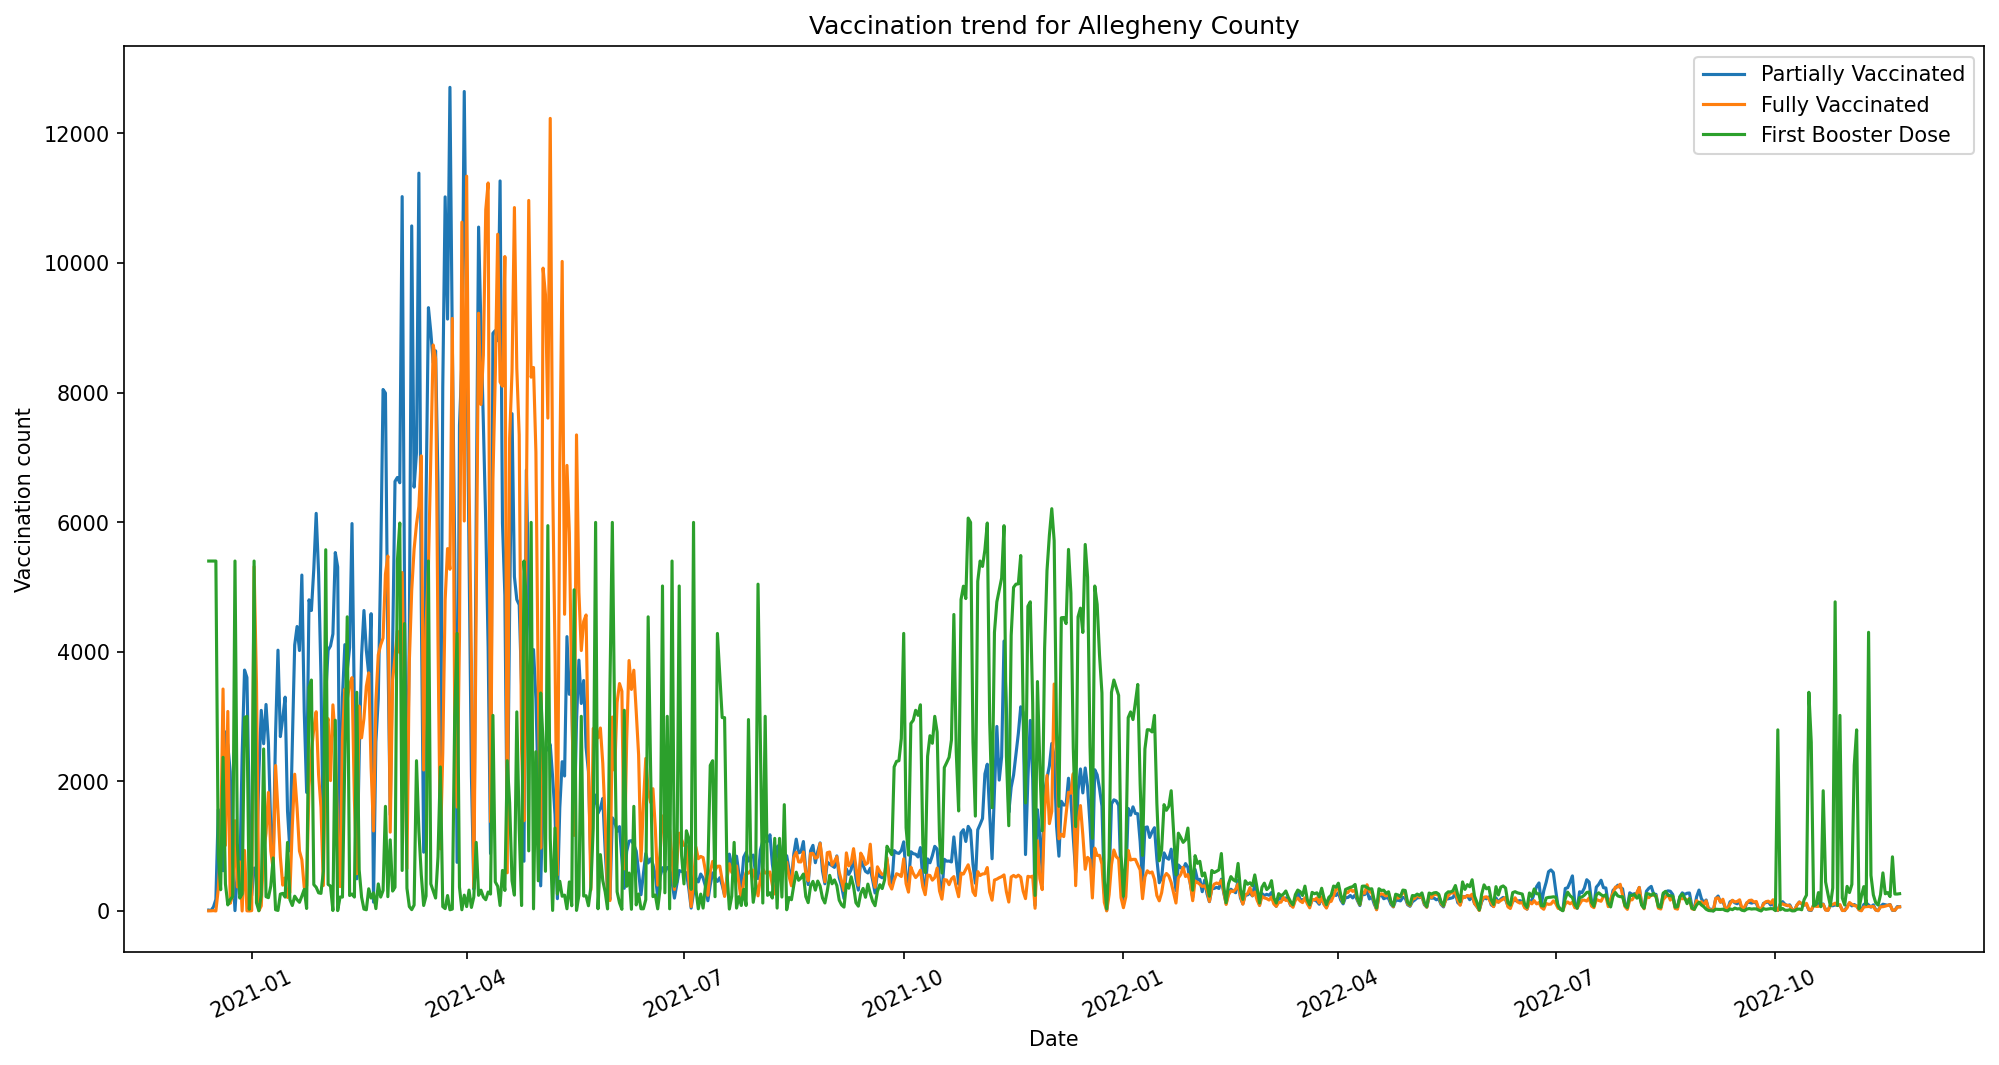

In [29]:
# create vaccination trend over time
plt.figure(figsize=(16,8), dpi = 150)
sns.lineplot(x = "Date", y = "Partially Vaccinated", data = df_Vaccinations_Allegheny)
sns.lineplot(x = "Date", y = "Fully Vaccinated", data = df_Vaccinations_Allegheny)
sns.lineplot(x = "Date", y = "First Booster Dose", data = df_Vaccinations_Allegheny)

plt.xlabel('Date')
plt.ylabel('Vaccination count')
plt.legend(['Partially Vaccinated', 'Fully Vaccinated', 'First Booster Dose'])
plt.title('Vaccination trend for Allegheny County')
plt.xticks(rotation = 25)
plt.savefig('plot5_vaccination_trend.jpeg')
plt.show()

**Comments** :
Even though cases increased exponentially the count of death did not. A major change during this period was introduction of vaccines in Allegheny County

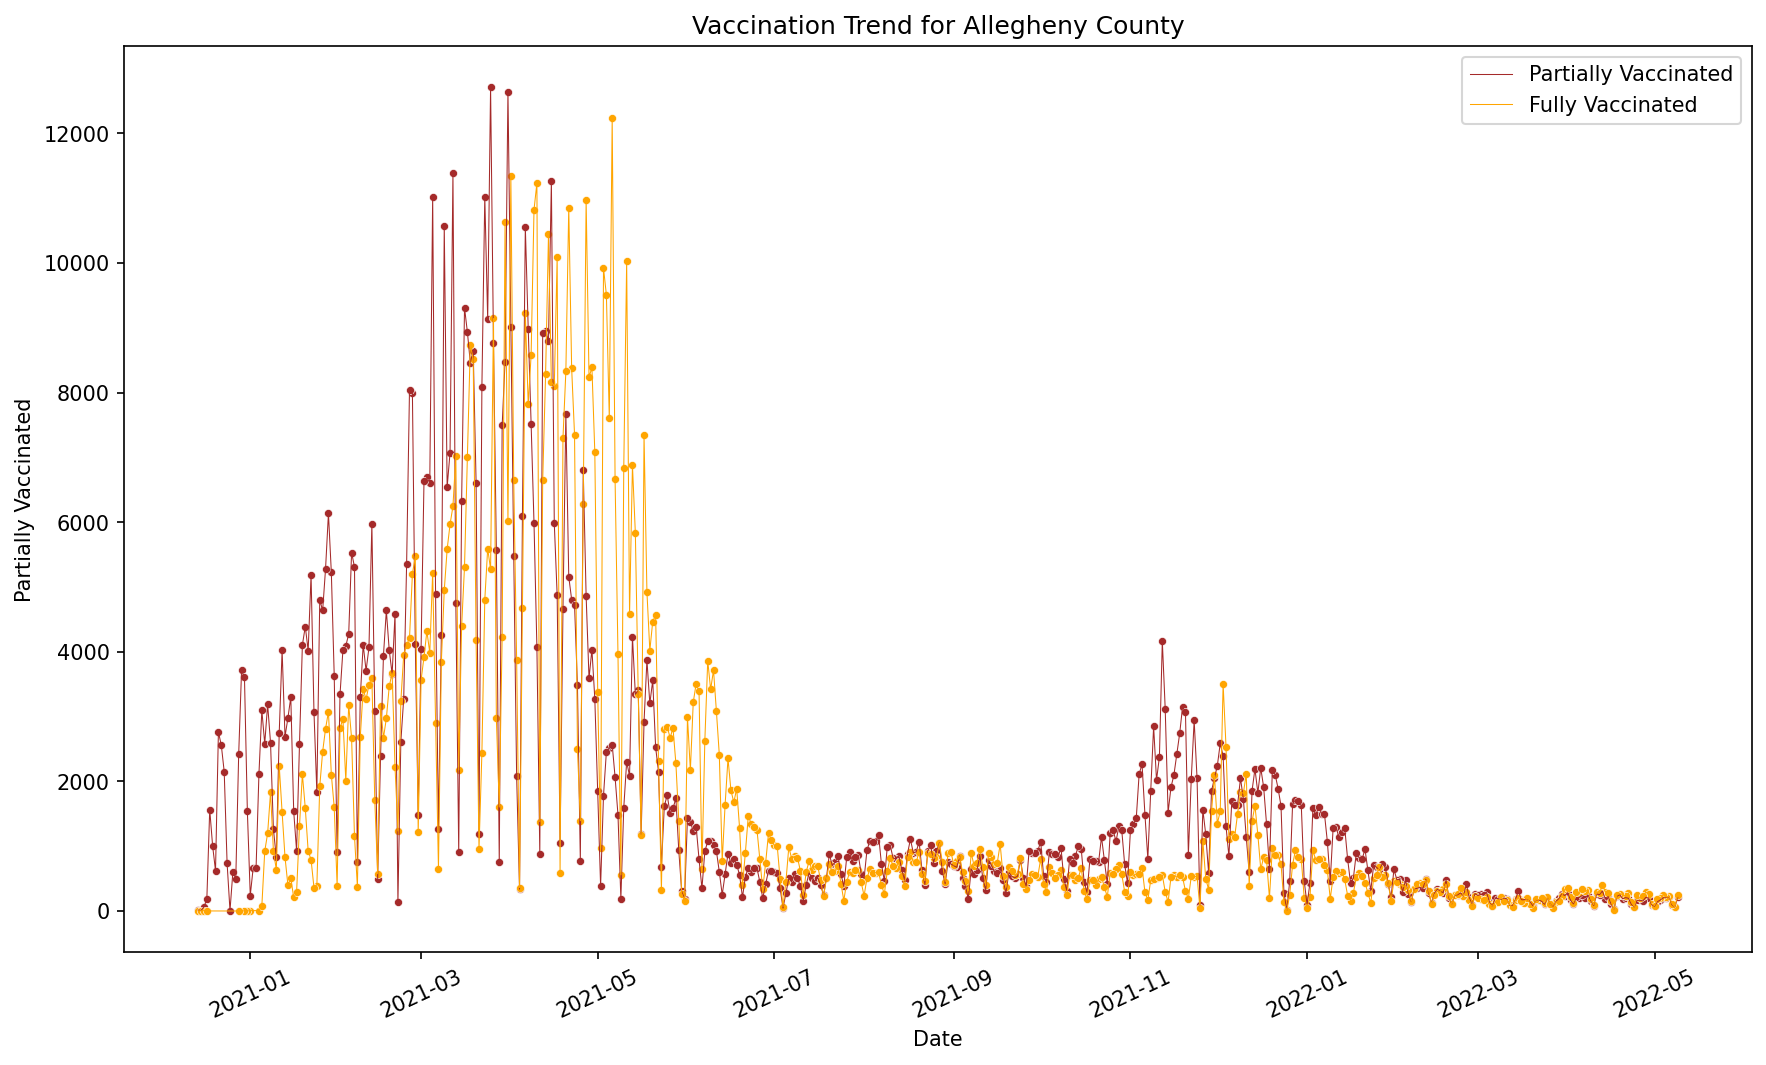

In [30]:
# vaccination patterns
plt.figure(figsize=(14,8), dpi = 150)

sns.lineplot(x = "Date", y = "Partially Vaccinated", data = df_Vaccinations_Allegheny_sub, linewidth = 0.5,color = 'brown')
sns.scatterplot(x = "Date", y = "Partially Vaccinated", data = df_Vaccinations_Allegheny_sub, color = 'brown', s = 15)
sns.lineplot(x = "Date", y = "Fully Vaccinated", data = df_Vaccinations_Allegheny_sub, linewidth = 0.5, color = 'orange')
sns.scatterplot(x = "Date", y = "Fully Vaccinated", data = df_Vaccinations_Allegheny_sub, color = 'orange', s = 15)

# sns.lineplot(x = "Date", y = "First Booster Dose", data = df_Vaccinations_Allegheny_sub, linewidth = 0.3, color = 'orange')
# sns.lineplot(x = "Date", y = "Second Booster Dose", data = df_Vaccinations_Allegheny_sub, linewidth = 0.3, color = 'brown')
plt.legend(['Partially Vaccinated', 'Fully Vaccinated'])
plt.xlabel('Date')
plt.title('Vaccination Trend for Allegheny County')
plt.savefig('plot6_partially_and_fully_vaccinated.jpeg')
plt.xticks(rotation = 25)
plt.show()

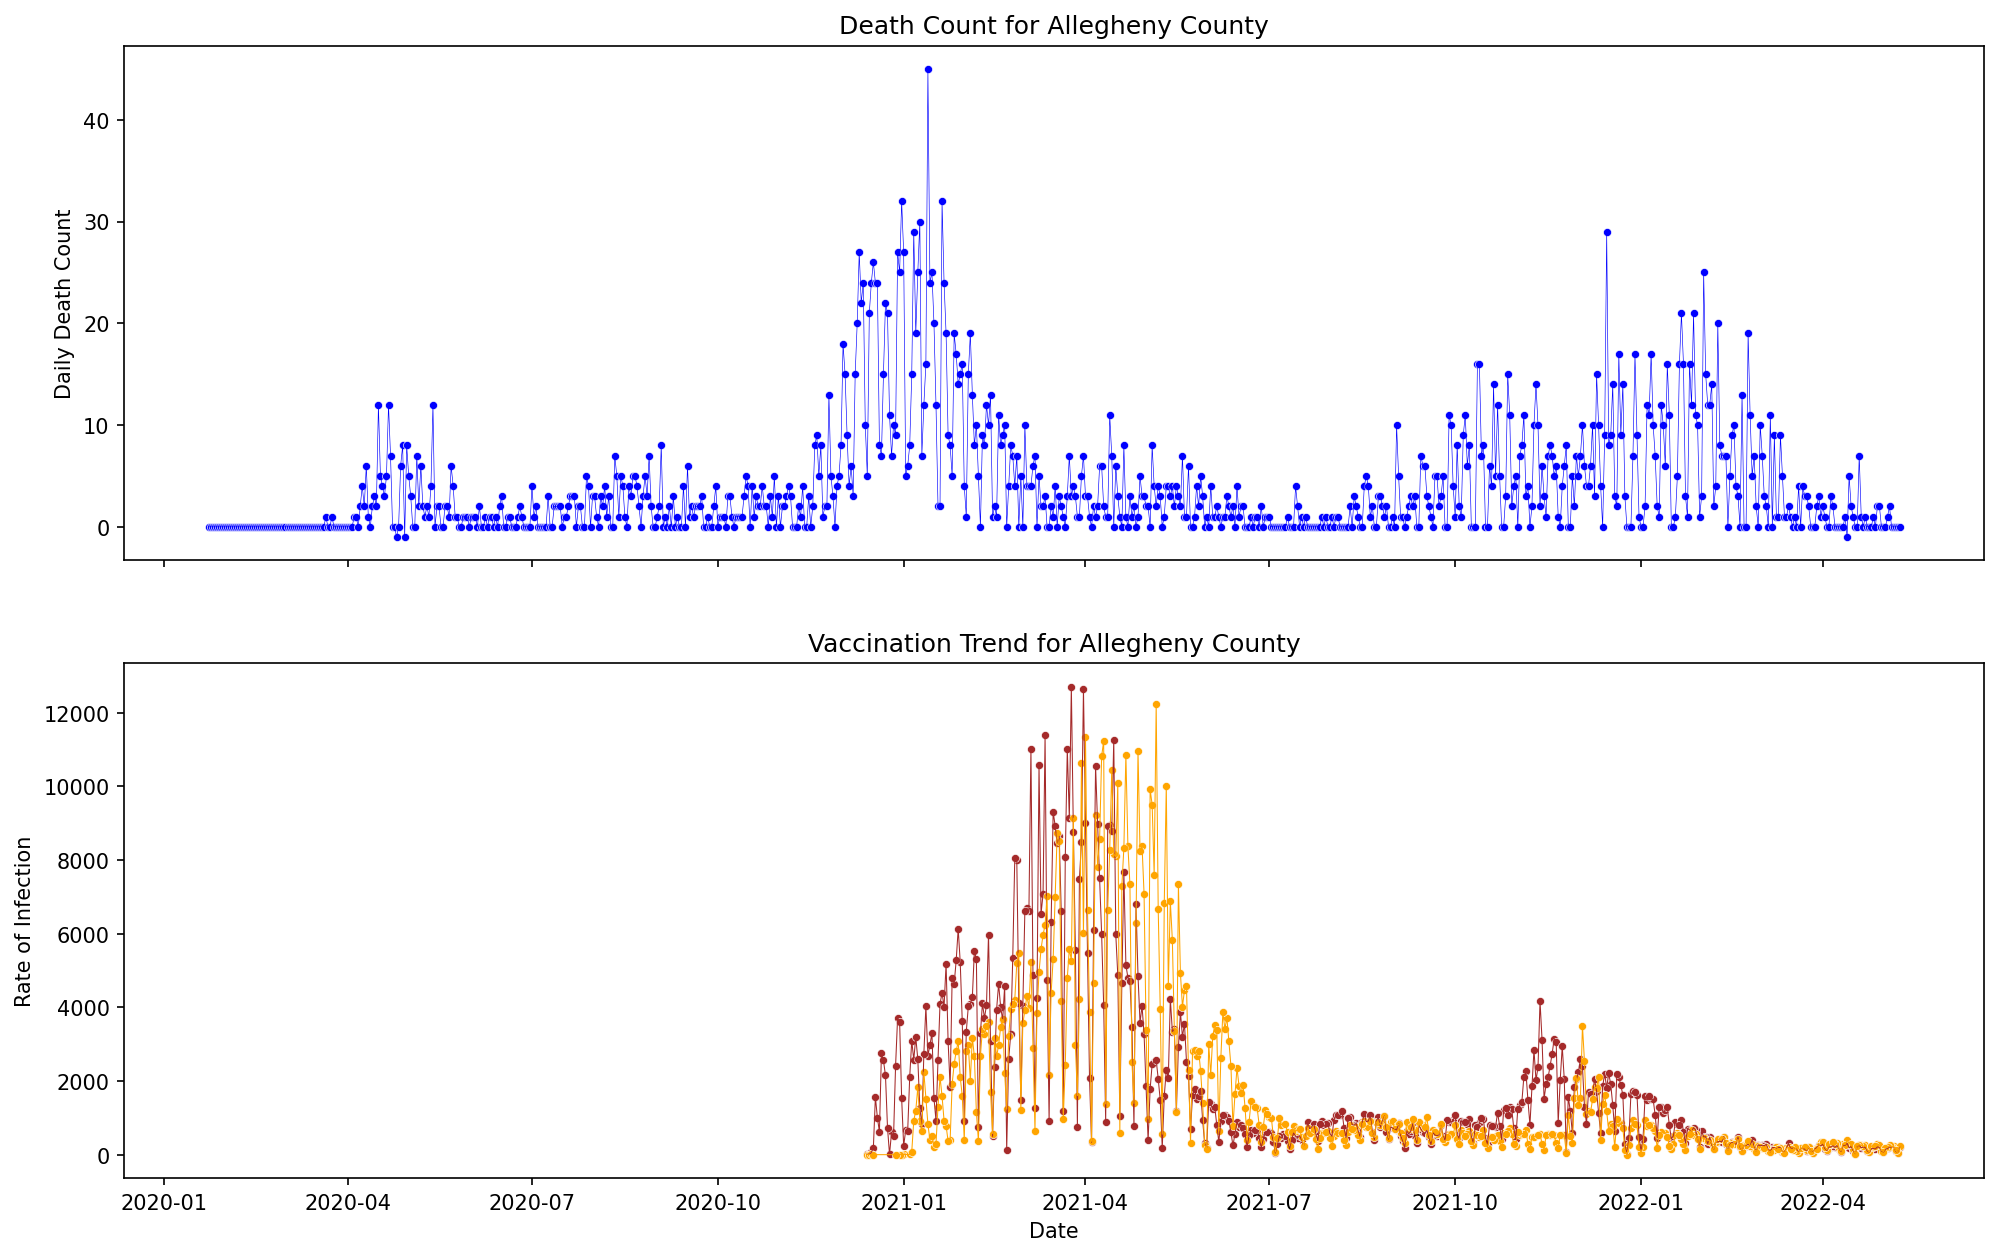

In [31]:
# death rate and vaccine count

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16,10), dpi = 150)

sns.lineplot(ax = axes[0], x = "date", y = "daily_death", data = df_covid_masking_combined_sub, linewidth = 0.3, color = 'b')
sns.scatterplot(ax = axes[0], x = "date", y = "daily_death", data = df_covid_masking_combined_sub,  color = 'b', s = 15)


sns.lineplot(ax = axes[1], x = "Date", y = "Partially Vaccinated", data = df_Vaccinations_Allegheny_sub, linewidth = 0.5,color = 'brown')
sns.scatterplot(ax = axes[1], x = "Date", y = "Partially Vaccinated", data = df_Vaccinations_Allegheny_sub, color = 'brown', s = 15)
sns.lineplot(ax = axes[1], x = "Date", y = "Fully Vaccinated", data = df_Vaccinations_Allegheny_sub, linewidth = 0.5, color = 'orange')
sns.scatterplot(ax = axes[1], x = "Date", y = "Fully Vaccinated", data = df_Vaccinations_Allegheny_sub, color = 'orange', s = 15)

# Set labels
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Daily Death Count')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Rate of Infection')

axes[0].set_title('Death Count for Allegheny County')
axes[1].set_title('Vaccination Trend for Allegheny County')
plt.savefig('plot7_subplot_deathcount_vaccinecount.jpeg')
plt.show()